
# Module Connection with urban levels

###### First, construction levels for hierarchical structure
###### Second, alignment of modules with hierarchical level 

# Figure
1. L_VS_R: Urban level versus urban spatial size
2. dc_VS_L: Module distance from home versus Module level
3. lc_num_distribution: Module level distribution plot
4. rc_num_distribution: Module radius distribution plot

# Robustness Test
1. Our defined urban levels
2. Administrative urban levels

In [1]:
import pandas as pd
import os
import networkx as nx
import numpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import math
import matplotlib as mpl
import scipy
import h3
import community as community_louvain
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.optimize import curve_fit
import numpy as np

def linear_fun(x, a, b):
    return a * np.asarray(x) + b

def fitting_powerlaw(x, y ,x_line,base):
    #base=10
    popt, cov = curve_fit(linear_fun, np.log(x+0.000001)/np.log(base), np.log(y+0.000001)/np.log(base))
    a, b = popt
    y_line = linear_fun(np.log(x_line+0.000001)/np.log(base), a, b)
    y_line = np.power(base, y_line)

    return a,b, x_line, y_line

def fitting_linear(x, y ,base):
    #base=10
    popt, cov = curve_fit(linear_fun, x, y)
    a, b = popt
    y_line = linear_fun(x, a, b)

    return a, b, x, y_line

In [3]:
def set_fig_style(ax1, xlabel,ylabel,ratio):
    labelfont  = 14*ratio
    tickfont   = 14*ratio
    #tickfont   = 10*ratio
    legendfont = 14*ratio
    ax1.tick_params(axis='both', which='both', direction="in", labelsize=tickfont, pad=8 )
    for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)
    for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)

    ax1.set_xlabel(xlabel, fontsize=labelfont, labelpad=labelfont )
    ax1.set_ylabel(ylabel,fontsize=labelfont, labelpad=labelfont )
    #ax1.legend(loc='upper right', fontsize=legendfont, frameon=False)

    #ax1.spines.right.set_visible(False)
    #ax1.spines.top.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Figures

In [11]:
########hierichal size plot
def L_VS_R(df_hierical_size_list,label_list,level_list,path_figure):
    fig, ax = plt.subplots(1, 1, figsize=(4.25,3.5))
    
    color_list=['#000000','#e41a1c', '#377eb8','#0f947e']
    df_fit=[]
    for df_hierical_size,label,marker,color in zip(df_hierical_size_list,label_list,['o','>','s'],color_list):
        df_hierical_size['radius']=np.log10(df_hierical_size['radius'])
        
        df=df_hierical_size.groupby(['level'])['radius'].mean().reset_index()

        ax.scatter(df['level'], df['radius'], marker =marker, s=60,facecolors='#377eb8', edgecolors='grey',label=label)
        
        df_fit.append(df[['level','radius']])

    df_fit=pd.concat(df_fit)
    a, b, xline, yline = fitting_linear(df_fit['level'].values, df_fit['radius'].values,df['level'].values)
    
    print(a,b)
    ax.plot(xline,yline,color='r',alpha=0.25,linewidth=3,label=r'$log(R) \sim$'+r'$~L$')
        
    set_fig_style(ax, 'Hierarchical level','Spatial radius '+ r'$(km)$',1)
    
    #handles, labels = plt.gca().get_legend_handles_labels()
    #order = [3,0,1,2]
    #ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

    
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    #ax.set_ylim(0,3)  #
    
    ax.set_xticks(level_list)
    ax.set_yticks([0,1,2,3])

    ax.set_yticklabels([r'$10^{0}$',r'$10^{1}$',r'$10^2$',  r'$10^3$'])
    plt.tight_layout()
    mpl.rcParams['pdf.fonttype']=42
    fig.savefig(path_figure, dpi=600)

In [5]:
def lc_num_distribution(df,label,path_figure):
    dfx=copy.deepcopy(df)
    fig, ax = plt.subplots(1, 1, figsize=(4.1, 3))
    print(df['level'].mean(),df['level'].median())

    df['count']=[1]*len(df)
    df=df.groupby(['level'])['count'].sum().reset_index()
    df['count']=df['count']/df['count'].sum()
    sns.barplot(df, x="level",y="count",color='#377eb8',alpha=0.8)
    
    sns.kdeplot(data=dfx, x="level",bw_adjust=3,ax=ax,fill=False,color='#377eb8',alpha=0.8)
    
    set_fig_style(ax, "Module spatial level, "+r'$L_c$', 'Fraction of module',0.85)
   
    
    ax.set_xlim(-0.5,7.5)
    ax.set_ylim(0,0.3)
    #ax.set_xticks([0,1,2,3,4,5,6])
    #ax.set_xticklabels([1,2,3,4,5,6,7],fontsize=12)
    
    plt.tight_layout()
    mpl.rcParams['pdf.fonttype']=42
    fig.savefig(path_figure+'urban_level_module'+label+'.pdf',dpi=600)



def rc_num_distribution(df,label,path_figure):

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Set up the plot
    
    # Draw the plotattraction
    counts, bins = np.histogram(np.log10(df['radius']+1), bins=50)
    #ax.scatter(bins[:len(counts)],counts/np.sum(counts))
    
    
    sns.kdeplot(df['radius'] , shade=True,bw_adjust=3,log_scale=True,ax=ax)
    #rint(np.mean(df['radius']*1000))
    #ax.set_xlim(1,1000000)
    
    ax.axvline(np.median(df['radius']),color='k')
    print(label,np.median(df['radius']))
    ax.set_xlim(1/1000,10000)
    #ax.set_ylim(0,0.12)
    
    set_fig_style(ax, 'Module radius (km), ' +r'$r_c$', 'Fraction of module',0.85)
    plt.tight_layout()
    mpl.rcParams['pdf.fonttype']=42
    fig.savefig(path_figure+'/urban_module_radius'+label+'.pdf',dpi=600)

In [6]:
def dc_VS_L(df_list,box_plot, path_figure):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    
    df_fit=[]
    for df_result,label,marker in zip(df_list,['US data', 'Senegal data','Ivory Coast data'],['o', '>','s']):
        df_result=df_result[df_result['level']!=-1]
        df_result=df_result.dropna()

        df_result['level_radius']=np.sqrt(df_result['level_area']/3.14)
        
        
        if box_plot==False:
            df_result['d_home'] = list(map(lambda x: int(math.log10(x+1)/0.25), df_result['d_home']))
   
            df=df_result.groupby(['d_home'])['level'].mean().reset_index()
    
            ax.scatter(df['d_home'], df['level'], marker =marker, s=60,facecolors='#377eb8', edgecolors='grey',zorder=1,label=label)
    
            df_fit.append(df[['d_home','level']])
        else:
            df_result['d_home'] = list(map(lambda x: int(math.log10(x+1)/1), df_result['d_home']))
            sns.boxplot(data=df_result, x="d_home", y="level",showfliers=False,showmeans=True,color='#377eb8')

    if box_plot==False:
        df_fit=pd.concat(df_fit)
        a, b, xline, yline = fitting_linear(df_fit['d_home'].values, df_fit['level'].values,np.log10(df['d_home'].values))
    
        ax.plot(xline,yline,color='r',alpha=0.25,linewidth=3,label=r'$L_c \sim$'+'$log(d_c)$',zorder=1)
        
        
        ax.legend(loc='upper left', fontsize=10, frameon=False)

        ax.set_xticks([0,4,8,12])
        ax.set_xticklabels([r'$10^{0}$',r'$10^{1}$',r'$10^2$',  r'$10^3$'])
        ax.set_ylim(1,7)
    else:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels([r'$10^{0}$',r'$10^{1}$',r'$10^2$',  r'$10^3$'])
    
    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$', "Module spatial level, " +r'$L_c$',1)
    
    
    plt.tight_layout()
    mpl.rcParams['pdf.fonttype']=42
    fig.savefig(path_figure+'urban_scale_d_home.pdf',dpi=600)

# Section 1. Topological hierchical urban structure

0.2668857129681088 0.054635858423916606


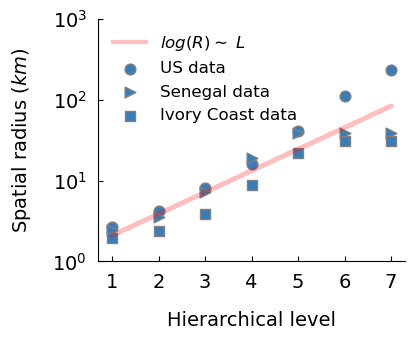

In [13]:
df_hierarchical_clustering_cuebiq=pd.read_csv('Results/Results_cuebiq/df_hierarchical_clustering_save.csv')

df_hierarchical_clustering_senegal=pd.read_csv('Results/Results_senegal/df_hierarchical_clustering_save.csv')

df_hierarchical_clustering_ivory=pd.read_csv('Results/Results_ivory/df_hierarchical_clustering_save.csv')

level_list=['level1','level2','level3','level4','level5','level6','level7']
level_list_num=np.arange(len(level_list))+1


df_hierical_size_list=[]
for df_result in  [df_hierarchical_clustering_cuebiq,df_hierarchical_clustering_senegal,df_hierarchical_clustering_ivory]:
    df_result['area']=list(map(lambda x: h3.cell_area(x, unit='km^2'), df_result['label']))

    df_hierical_size=[]    
    for columns,level in zip(level_list,level_list_num):
        df_temp=df_result.groupby(columns)['area'].sum().reset_index()
        df_temp['radius']=np.sqrt(df_temp['area']/3.14)
        df_temp['level']=[level]*len(df_temp)
        df_hierical_size.append(df_temp)
    df_hierical_size=pd.concat(df_hierical_size)
    df_hierical_size_list.append(df_hierical_size)

label_list=['US data','Senegal data','Ivory Coast data']
L_VS_R(df_hierical_size_list,label_list,level_list_num,'Results/Results_cuebiq/urban_scale/cluster/urban_scale.png')

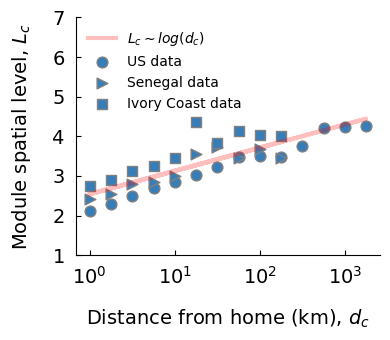

In [8]:
####alignment

case='cluster'
df_result_cuebiq=pd.read_csv('Results/Results_cuebiq/module_urban_level_'+case+'.csv')


df_result_senegal=pd.read_csv('Results/Results_senegal/module_urban_level_'+case+'.csv')

df_result_ivory=pd.read_csv(('Results/Results_ivory/module_urban_level_'+case+'.csv'))

dc_VS_L([df_result_cuebiq,df_result_senegal,df_result_ivory],False,'Results/Results_cuebiq/urban_scale/cluster/')



2.642698842649594 2.0
10km 5.12857880520729
3.838120104438642 4.0
100km 19.12557810843888
4.797979797979798 5.0
1000km 86.00439133132801


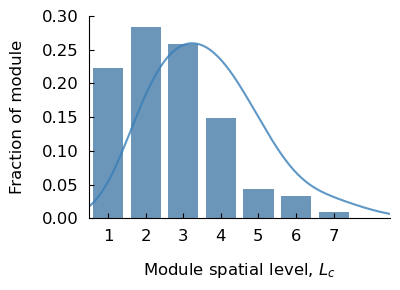

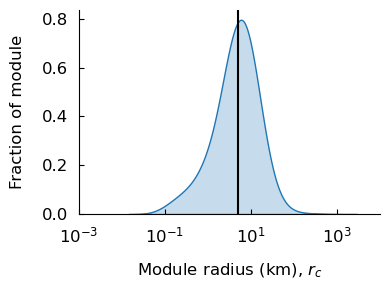

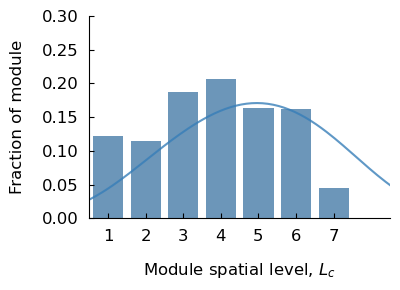

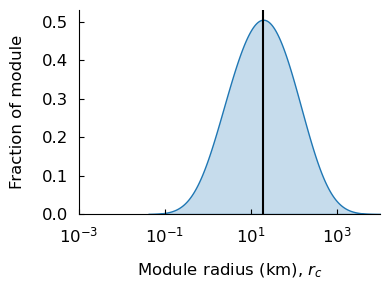

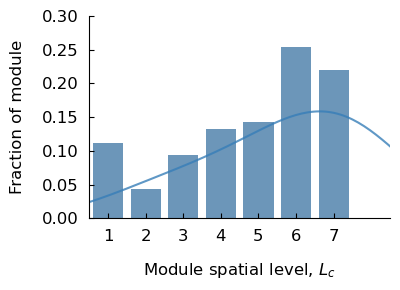

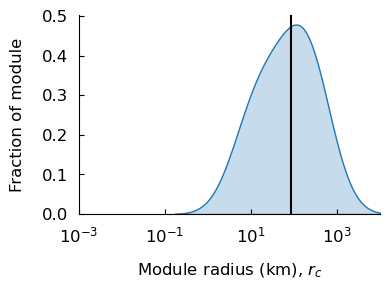

In [9]:
case='cluster'
df_result_cuebiq=pd.read_csv('Results/Results_cuebiq/module_urban_level_'+case+'.csv')
df_result_cuebiq=df_result_cuebiq[df_result_cuebiq['level']>=1]

df1=df_result_cuebiq[(df_result_cuebiq['d_home']>8)&(df_result_cuebiq['d_home']<12)]

df2=df_result_cuebiq[(df_result_cuebiq['d_home']>80)&(df_result_cuebiq['d_home']<120)]

df3=df_result_cuebiq[(df_result_cuebiq['d_home']>800)&(df_result_cuebiq['d_home']<1200)]

for df, label in zip([df1,df2,df3],['10km', '100km','1000km']):
    lc_num_distribution(df,label,'Results/Results_cuebiq/urban_scale/cluster/')
    rc_num_distribution(df,label,'Results/Results_cuebiq/urban_scale/cluster/')

# Section 2. Connection with administrative urban levels


In [7]:
#from area import area

import geopandas as gpd

import shapefile

In [8]:

gdf1 = gpd.read_file("Dataset/gdf1.shp") ####regions
gdf2 = gpd.read_file("Dataset/gdf2.shp") ####states
gdf3 = gpd.read_file("Dataset/gdf3.shp") ####county
gdf4 = gpd.read_file("Dataset/gdf4.shp") ####county divisons

df1=gdf1[['radius']]
df1['level']=[4]*len(df1)

df2=gdf2[['radius']]
df2['level']=[3]*len(df2)

df3=gdf3[['radius']]
df3['level']=[2]*len(df3)

df4=gdf4[['radius']]
df4['level']=[1]*len(df4)

print(df1['radius'].mean())
print(df2['radius'].mean())
print(df3['radius'].mean())
print(df4['radius'].mean())

1281.3000360440947
213.90658309009567
26.079056070239105
6.460650631213895


0.7728284687288955 -0.13082349926773507


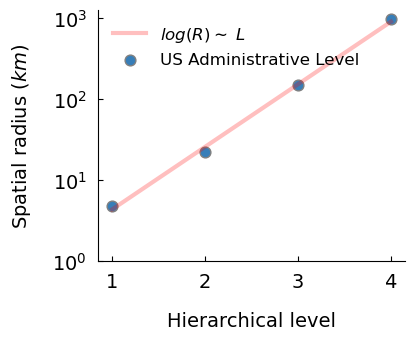

In [12]:

level_list=['level1','level2','level3','level4']
level_list_num=np.arange(len(level_list))+1
df_hierichal=pd.concat([df1,df2,df3,df4])
L_VS_R([df_hierichal],['US Administrative Level'],level_list_num,'Results/Results_cuebiq/urban_scale/administrative/urban_scale.png')

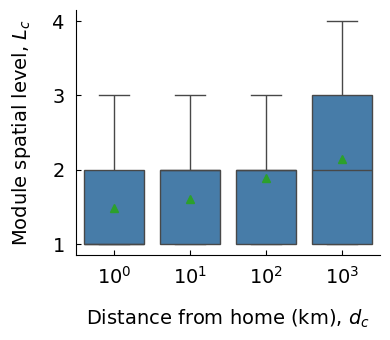

In [10]:
case='administrative'
df_result_cuebiq=pd.read_csv('Results/Results_cuebiq/module_urban_level_'+case+'.csv')

dc_VS_L([df_result_cuebiq],True,'Results/Results_cuebiq/urban_scale/'+case+'/')